# Project 3

- Load (symmetric) TSP data from http://www.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/ 
- For opening the data use https://github.com/tsartsaris/TSPLIB-python-parser
- Apply the MMAS algorithm described in the exercise sheet

In [7]:
import itertools as it
import time
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [8]:
'''
    Max-Mint Ant System for solving the traveling salesman problem
    Parameters:
        G - mapping of nodes with their coordinates
        OPT - length of the optimal route (given with the dataset)
    Optional values (given as keyword arguments):
        rho  (default: 1 / n)
        tau_min  (default: 1 / n**2)
        tau_max  (default: n - 1 / n)
        alpha  (default: 1)
        beta  (default: 0)
'''
class MMAS:
    def __init__(self, G, OPT, **kwargs):
        self.N, self.n, self.am = self._process_graph(G)
        self.OPT = OPT
        self.start_time = None
        self.results = None
        self.wall_clock_time = kwargs.get('wall_clock_time') or 10 * 60
        # Pheromone values stored in an adjacent matrix (initial 1 / n for each edge, otherwise 0)
        self.tau = self._init_tau()
        # Parameters of the algorithm
        self.rho = kwargs.get('rho') or 1 / self.n
        self.tau_min = kwargs.get('tau_min') or 1 / self.n**2
        self.tau_max = kwargs.get('tau_max') or self.n - 1 / self.n
        self.alpha = kwargs.get('alpha') or 1
        self.beta = kwargs.get('beta') or 0
        
    def _process_graph(self, G):
        n = len(G)
        # Assuming that the ids are from 1 to n
        N = np.arange(n)
        positions = np.zeros((n, 2), dtype=np.float)
        # Collect all positions assuming that the nodes are sorted by id
        positions = [(float(x), float(y)) for x, y in G.values()]
        # Generate adjacent matrix containing the euclidean distances between nodes
        am = np.zeros((n, n), dtype=np.float)
        for i, j in it.combinations(N, 2):
            i_x, i_y = positions[i]
            j_x, j_y = positions[j]
            am[i, j] = am[j, i] = np.hypot((i_x - j_x), (i_y - j_y))
        return N, n, am
        
    def _init_tau(self):
        return np.array([[1 / self.n for x in range(self.n)] for y in range(self.n)])

    #--------------------------------------------------------------------------------------------------------------
    # Methods for execution
    #--------------------------------------------------------------------------------------------------------------
    
    def _route_length(self, x):
        # Sum up the distances between all traversed nodes
        return sum([self.am[x[i], x[i+1]] for i in range(len(x) - 1)])
    
    def _is_optimum_found(self, x):
        # Optimal value found or the wall clock time is reached
        return (self._route_length(x) == self.OPT or
                time.time() - self.start_time > self.wall_clock_time)
    
    def _update_tau(self, route):
        # Update self.tau regarding the path x (list of visited nodes)
        # TODO rename
        tau = np.zeros((self.n, self.n))
        # Update all edges traversed by the given route
        for i in range(len(route) - 1):
            x, y = route[i], route[i + 1]
            tau[x, y] = tau[y, x] = min((1 - self.rho) * self.tau[x, y] + self.rho, self.tau_max)
        # Update all not traversed edges
        for x, y in it.combinations_with_replacement(self.N, 2):
            if not tau[x, y]:
                tau[x, y] = tau[y, x] = max((1 - self.rho) * self.tau[x, y], self.tau_min)
        self.tau = tau
    
    def _construct(self):
        # Create a route based on the pheromone values in self.tau
        route = np.empty(self.n, dtype=np.int)
        # Setup a visited array to prevent visiting a node twice
        visited = np.zeros(self.n, dtype=np.bool)
        # Start at a random node
        # TODO vllt nicht random?
        route[0] = np.random.randint(self.n)
        visited[route[0]] = True
        for i in range(self.n - 1):
            v_k = route[i]
            left_nodes = np.array([(z, self.tau[v_k, z]**self.alpha / self.am[v_k, z]**self.beta)
                                   for z in self.N if not visited[z]])
            assert np.all(left_nodes >= 0), left_nodes
            R = left_nodes[:, 1].sum()
            assert R != 0, 'route: {}, left: {}'.format(route, left_nodes)
            route[i + 1] = np.random.choice(left_nodes[:, 0], p=left_nodes[:, 1] / R)
            visited[route[i + 1]] = True
        return route
    
    def _averaged_results(self, N):
        # https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
        rm = np.convolve(self.results, np.ones((N,))/N, mode='valid')
        filler = [None] * ((len(self.results) - len(rm)) // 2)
        return np.array(filler + list(rm) + filler)
    
    def plot(self):
        fig_length = max(8, min(18, len(self.results) // 400))
        fig, ax = plt.subplots(1, 1, figsize=(fig_length, 4))
        ax.plot(self.results)
        ax.plot(self._averaged_results(10), color="red")
        ax.plot(self._averaged_results(100), color="green")
        ax.set_xlim([0, len(self.results)])
        ax.set_title('MMAS - Intermediate results, best value: {:.2f}'.format(self.best_x_value))
        ax.set_xlabel('Step')
        ax.set_ylabel('Route length')
        fig.tight_layout()
        
    def __call__(self, plot=True):
        self.start_time = time.time()
        self.best_x = self._construct()
        self.best_x_value = self._route_length(self.best_x)
        self.results = [self.best_x_value]
        self._update_tau(self.best_x)
        while not self._is_optimum_found(self.best_x):
            x = self._construct()
            self.results.append(self._route_length(x))
            if self.results[-1] < self.best_x_value:
                self.best_x = x
                self.best_x_value = self.results[-1]
            self._update_tau(self.best_x)
        if plot:
            self.plot()
        return self.best_x_value, self.best_x

In [34]:
# copied from https://github.com/tsartsaris/TSPLIB-python-parser/blob/master/parser.py

import re

cities_set = []
cities_tups = []
cities_dict = {}

def read_tsp_data(tsp_name):
    with open(tsp_name) as f:
        content = f.read().splitlines()
        cleaned = [x.lstrip() for x in content if x != ""]
        return cleaned
    
def detect_dimension(in_list):
    non_numeric = re.compile(r'[^\d]+')
    for element in in_list:
        if element.startswith("DIMENSION"):
            return non_numeric.sub("",element)
        
def get_cities(list,dimension):
    dimension = int(dimension)
    for item in list:
        for num in range(1, dimension + 1):
            if item.startswith(str(num)):
                index, space, rest = item.partition(' ')
                if rest not in cities_set:
                    cities_set.append(rest)
    return cities_set

def city_tup(list):
    for item in list:
        first_coord, space, second_coord = item.partition(' ')
        cities_tups.append((first_coord.strip(), second_coord.strip()))
    return cities_tups

def create_cities_dict(cities_tups):
    return dict(zip((range(1,len(cities_tups)+1)),cities_tups))

def load_data():
    #TODO:
    # Sample data from the python library
    data = read_tsp_data("data/att48.tsp")
    dimension = detect_dimension(data)
    cities_set = get_cities(data,dimension)
    cities_tups = city_tup(cities_set)
    cities_dict = create_cities_dict(cities_tups)
    
    return cities_dict
    
    return dict([(1, ('38.24', '20.42')), (2, ('39.57', '26.15')), (3, ('40.56', '25.32')), (4, ('36.26', '23.12')), (5, ('33.48', '10.54')), (6, ('37.56', '12.19')), (7, ('38.42', '13.11')), (8, ('37.52', '20.44')), (9, ('41.23', '9.10')), (10, ('41.17', '13.05')), (11, ('36.08', '-5.21')), (12, ('38.47', '15.13')), (13, ('38.15', '15.35')), (14, ('37.51', '15.17')), (15, ('35.49', '14.32')), (16, ('39.36', '19.56'))])

{1: ('6734', '1453'), 2: ('2233', '10'), 3: ('5530', '1424'), 4: ('401', '841'), 5: ('3082', '1644'), 6: ('7608', '4458'), 7: ('7573', '3716'), 8: ('7265', '1268'), 9: ('6898', '1885'), 10: ('1112', '2049'), 11: ('5468', '2606'), 12: ('5989', '2873'), 13: ('4706', '2674'), 14: ('4612', '2035'), 15: ('6347', '2683'), 16: ('6107', '669'), 17: ('7611', '5184'), 18: ('7462', '3590'), 19: ('7732', '4723'), 20: ('5900', '3561'), 21: ('4483', '3369'), 22: ('6101', '1110'), 23: ('5199', '2182'), 24: ('1633', '2809'), 25: ('4307', '2322'), 26: ('675', '1006'), 27: ('7555', '4819'), 28: ('7541', '3981'), 29: ('3177', '756'), 30: ('7352', '4506'), 31: ('7545', '2801'), 32: ('3245', '3305'), 33: ('6426', '3173'), 34: ('4608', '1198'), 35: ('23', '2216'), 36: ('7248', '3779'), 37: ('7762', '4595'), 38: ('7392', '2244'), 39: ('3484', '2829'), 40: ('6271', '2135'), 41: ('4985', '140'), 42: ('1916', '1569'), 43: ('7280', '4899'), 44: ('7509', '3239'), 45: ('10', '2676'), 46: ('6807', '2993'), 47: ('51

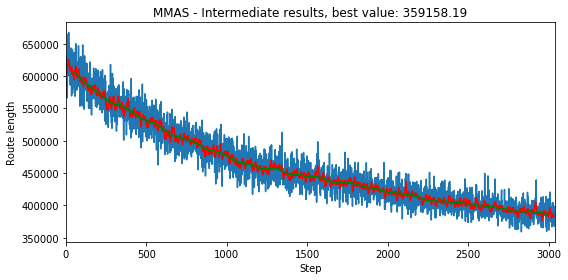

In [33]:
np.random.seed(0)  # Always receive the same random decisions
data = load_data()  # Get optimal value and pass it to MMAS constructor
# For the beginning test for only a few seconds - Later: 10 * 60 (10 minutes)
mmas = MMAS(data, -1, wall_clock_time=60*3)
print(mmas(plot=False))
mmas.plot()
# Current best result: (53.613033599139548, array([ 2,  1,  3,  7,  0, 15, 12, 13, 11,  6,  9,  8,  5, 14,  4, 10]))

### Different settings

    1.) "Also use heuristic information ($\beta$ = 4)"
    2.) "Try out a number of parameter settings (or use some automatic parameter tuning, if you feel like that)."
    3.) -> Figure out some good parameter settings
    4.) "Test your algorithm on some small TSP-instances (from TSPLib, only symmetric instances). How large can the instances be so that your algorithm can still find a good solution which is only some percent above the Heuristic Optimization optimum? You may modify your algorithm as you like, for example by sending multiple ants each round and then choosing the best tour."
    5.) Document your strategies, your results and your resources used (“four cores at 2.3GHz for 24 hours. . . ”)"

##### Use heuristic information ($\beta$ = 4)

{1: ('6734', '1453'), 2: ('2233', '10'), 3: ('5530', '1424'), 4: ('401', '841'), 5: ('3082', '1644'), 6: ('7608', '4458'), 7: ('7573', '3716'), 8: ('7265', '1268'), 9: ('6898', '1885'), 10: ('1112', '2049'), 11: ('5468', '2606'), 12: ('5989', '2873'), 13: ('4706', '2674'), 14: ('4612', '2035'), 15: ('6347', '2683'), 16: ('6107', '669'), 17: ('7611', '5184'), 18: ('7462', '3590'), 19: ('7732', '4723'), 20: ('5900', '3561'), 21: ('4483', '3369'), 22: ('6101', '1110'), 23: ('5199', '2182'), 24: ('1633', '2809'), 25: ('4307', '2322'), 26: ('675', '1006'), 27: ('7555', '4819'), 28: ('7541', '3981'), 29: ('3177', '756'), 30: ('7352', '4506'), 31: ('7545', '2801'), 32: ('3245', '3305'), 33: ('6426', '3173'), 34: ('4608', '1198'), 35: ('23', '2216'), 36: ('7248', '3779'), 37: ('7762', '4595'), 38: ('7392', '2244'), 39: ('3484', '2829'), 40: ('6271', '2135'), 41: ('4985', '140'), 42: ('1916', '1569'), 43: ('7280', '4899'), 44: ('7509', '3239'), 45: ('10', '2676'), 46: ('6807', '2993'), 47: ('51

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in less


(342868.36818650365, array([ 28,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96, 103, 104, 133, 126, 139, 113, 102,
       123, 131, 125, 101, 132, 114, 122, 138, 112, 141, 128, 115, 142,
       116, 127, 134, 108, 120, 109, 118, 106, 107, 110, 135,  98, 117,
       111, 136, 129, 100, 143, 119, 105, 130, 140,  99, 121, 137,  97, 124]))


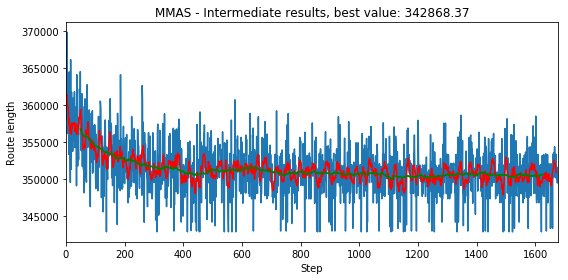

In [32]:
np.random.seed(0)  # Always receive the same random decisions
data = load_data()  # Get optimal value and pass it to MMAS constructor
mmas = MMAS(data, -1, wall_clock_time=60, beta=4)
print(mmas(plot=False))
mmas.plot()

Using heuristic information ends up finding the optimal value much faster.

##### Finding good parameters
-> Use: http://scikit-learn.org/stable/modules/cross_validation.html

In [ ]:
# TODO:

### Extra credits

    1.) "Solving an instance from TSPLib with at least 40 cities optimally;"
    2.) "Solving an instance from TSPLib with at least 100 cities at most 1% worse than the optimum tour length;"
    3.) "Solving an instance from TSPLib with at least 1000 cities at most 30% worse than the optimum tour length;"
    4.) "Being the team which solved the highest-number-of-cities instance from TSPLib at most 50% worse than the optimum tour length."

"You might need to tune your algorithms some to make them good enough for these
extra credit items (and there is no time limit on these). Feel free to google for ideas
for how to improve ACO algorithms (I can recommend the paper by Stützle and Hoos
from 2000, Max-Min Ant System). Document your strategies, your results and your
resources used (“four cores at 2.3GHz for 24 hours. . . ”)."